In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st #chi-2
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [2]:
transactions = pd.read_csv('transactions.csv')
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')

## Nettoyage des données
Mission n° 1

Avant de pouvoir entrer dans le vif du sujet, il vous faudra faire un peu de nettoyage ! Par exemple, vous devrez faire des choix quant au traitement des valeurs manquantes et des valeurs aberrantes.

1 - TRANSACTIONS

In [3]:
transactions

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242
...,...,...,...,...
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5


In [4]:
transactions.describe(include = 'all')

,id_prod,date,session_id,client_id
count,337016,337016,337016,337016
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,1081,13,200,12855


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [6]:
#Dénombrement des valeurs manquantes
transactions.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [7]:
#Il y a des valeurs "test_***" à supprimer car certaines sont en doubles et ce sont des essais. 
#On les retrouves toutes sous "session_id" = s_O.
pd.set_option('mode.chained_assignment', None)
transactions = transactions.drop_duplicates()
transactions

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242
...,...,...,...,...
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5


In [8]:
#Affichage des données associées aux sessions de test
transactions.loc[transactions['session_id'] == 's_0']

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
...,...,...,...,...
264317,T_0,test_2021-03-01 02:30:02.237416,s_0,ct_1
288918,T_0,test_2021-03-01 02:30:02.237415,s_0,ct_1
293107,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0
298399,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1


In [9]:
index_s_0 = transactions[transactions['session_id'] == 's_0'].index.values
transactions.drop(index_s_0, inplace=True)
transactions.loc[transactions['session_id'] == 's_0']

,id_prod,date,session_id,client_id


Analyse des types

In [10]:
print(transactions.dtypes)

id_prod       object
date          object
session_id    object
client_id     object
dtype: object


In [11]:
#Toutes les variables sont "object" mais "date" peut-être transformé en "datetime"
transactions['date'] = pd.to_datetime(transactions['date'])
print(transactions.dtypes)

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object


In [12]:
#Cela permet de classer facile la table par ordre chronologique
transactions = transactions.sort_values('date')
transactions = transactions.set_index('date')
print(transactions.head())

                           id_prod session_id client_id
date                                                   
2021-03-01 00:01:07.843138  0_1259        s_1     c_329
2021-03-01 00:02:26.047414  0_1390        s_2     c_664
2021-03-01 00:02:38.311413  0_1352        s_3     c_580
2021-03-01 00:04:54.559692  0_1458        s_4    c_7912
2021-03-01 00:05:18.801198  0_1358        s_5    c_2033


2 - PRODUCTS

In [13]:
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


In [14]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [15]:
#On peut modifier "categ" en variable catégorielle, et classer la table par catégorie
products['categ'] = products['categ'].astype('category')
products.dtypes

products = products.sort_values('categ')
products

,id_prod,price,categ
0,0_1421,19.99,0
1985,0_724,21.78,0
1986,0_1467,4.99,0
1988,0_1076,25.11,0
1989,0_2211,9.99,0
...,...,...,...
719,2_223,175.99,2
1272,2_7,69.99,2
1729,2_84,182.30,2
1284,2_211,203.99,2


In [16]:
#Vérification de la présence de valeurs manquantes
products.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [17]:
#Vérification de la présence de doublons
duplicated = products.duplicated()
products[duplicated]

,id_prod,price,categ


In [18]:
products_test = products.sort_values('price', ascending=True)
products_test

,id_prod,price,categ
731,T_0,-1.00,0
2272,0_528,0.62,0
2355,0_202,0.62,0
370,0_120,0.66,0
1211,0_1844,0.77,0
...,...,...,...
2779,2_30,233.54,2
1436,2_167,236.99,2
394,2_158,247.22,2
724,2_76,254.44,2


In [19]:
#On supprime les id_prod "T_0", comme fait précédemment dans le fichier transactions, car ils correspondent à des tests
#et son prix est de -1 EUR
products.drop(731, inplace=True)
products.loc[products['id_prod'] == 'T_0']

,id_prod,price,categ


3 - CLIENTS

In [20]:
customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [21]:
print(customers.dtypes)

client_id    object
sex          object
birth         int64
dtype: object


In [22]:
#La variable "sex" peut être passée en catégorielle
customers['sex'] = customers['sex'].astype('category')
customers.dtypes

client_id      object
sex          category
birth           int64
dtype: object

In [23]:
#Recherche de valeurs manquantes
customers.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [24]:
#Recherche de données dupliquées
duplicated_customers = customers.duplicated()
customers[duplicated_customers]

,client_id,sex,birth


In [25]:
#Suppression des clients (ct_0 et ct_1) associés aux sessions de test
ct_0 = customers.loc[customers['client_id'] == 'ct_0']
ct_1 = customers.loc[customers['client_id'] == 'ct_1']
print(ct_0)
print(ct_1)

     client_id sex  birth
2735      ct_0   f   2001
     client_id sex  birth
8494      ct_1   m   2001


In [26]:
customers.drop([2735, 8494], inplace=True)
customers.sort_values('client_id')

,client_id,sex,birth
4299,c_1,m,1955
6894,c_10,m,1956
2137,c_100,m,1992
8472,c_1000,f,1966
3426,c_1001,m,1982
...,...,...,...
7004,c_995,m,1955
2788,c_996,f,1970
94,c_997,f,1994
2145,c_998,m,2001


4 - DATAFRAMES

In [27]:
#Si des id_prod sont présents dans transactions mais pas dans products, alors on doit les supprimer car ils ne seront 
#pas associés à un prix dans products
transactions['id_prod_prod'] = transactions['id_prod'].isin(products['id_prod'])
transactions['client_id_custom'] = transactions['client_id'].isin(customers['client_id'])
transactions

,id_prod,session_id,client_id,id_prod_prod,client_id_custom
date,,,,,
2021-03-01 00:01:07.843138,0_1259,s_1,c_329,True,True
2021-03-01 00:02:26.047414,0_1390,s_2,c_664,True,True
2021-03-01 00:02:38.311413,0_1352,s_3,c_580,True,True
2021-03-01 00:04:54.559692,0_1458,s_4,c_7912,True,True
2021-03-01 00:05:18.801198,0_1358,s_5,c_2033,True,True
...,...,...,...,...,...
2022-02-28 23:56:57.196281,1_456,s_172422,c_5787,True,True
2022-02-28 23:56:57.561424,1_370,s_172423,c_1460,True,True
2022-02-28 23:57:12.741573,0_1538,s_172424,c_1876,True,True


In [28]:
#Si id_prod_prod = False, alors id_prod est uniquement dans transactions
id_prod_false = transactions[transactions['id_prod_prod'] == False]
id_prod_false = id_prod_false.groupby('id_prod').count()
id_prod_false

,session_id,client_id,id_prod_prod,client_id_custom
id_prod,,,,
0_2245,103,103,103,103


In [29]:
products_0_2245 = products.loc[products['id_prod'] == '0_2245']
products_0_2245

,id_prod,price,categ


In [30]:
#0_2245 n'est donc pas présent dans produits mais dans transactions. Or il a été acheté 103 fois et il faudrait l'inclure 
#dans l'analyse. On peut donc lui attribuer, comme prix, la moyenne des prix de sa catégorie
transactions_m = pd.merge(transactions, products, on=['id_prod']) 
transactions_m = pd.pivot_table(index='id_prod', columns='categ', values='price', aggfunc=np.mean, data=transactions_m)
moy_cat0 = transactions_m[0].mean(skipna=True)
moy_cat0

11.718568310781317

In [31]:
#On attribue ce nouveau prix à 0_2245 dans products
products.loc[3287] = {'id_prod' : '0_2245', 'price' : 11.72, 'categ' : 0}
products.loc[3287]

id_prod    0_2245
price       11.72
categ           0
Name: 3287, dtype: object

In [32]:
df = pd.merge(transactions, customers, on='client_id')
df = pd.merge(df, products, on = 'id_prod')
df['count'] = 1
df['count'] = df['count'].astype(int)

In [33]:
df['count'] = df.groupby('client_id').size().reset_index(name='count')['count']
df = df.sort_values('count', ascending=False)
df = df[['client_id', 'count']]
df = pd.merge(df, customers, on='client_id')
df = df.sort_values('count', ascending=False)
top_10 = df.iloc[0:10]
print(top_10)

    client_id    count sex  birth
0      c_5924  12855.0   f   1982
96     c_4080   4473.0   f   1972
117    c_6064   3275.0   m   1970
159    c_4157   2562.0   f   1951
271    c_2157    195.0   m   1971
199    c_1326    195.0   f   1958
415    c_4326    193.0   f   1968
311    c_6328    193.0   m   1976
483    c_5590    190.0   m   1984
598     c_669    189.0   m   1988


In [34]:
#On peut constater ci-dessus que les 4 premiers clients ont un montant d'achat bien supérieur au reste des clients. 
#Il est donc préférable de les enlever car cela fausserait les futures analyses.
mask = transactions.loc[(transactions['client_id'] == 'c_1609') | (transactions['client_id'] =='c_6714') | (transactions['client_id'] =='c_3454') | (transactions['client_id'] =='c_4958')]
top_clients = mask.index.tolist()
transactions = transactions.drop(top_clients)

In [35]:
df['count'] = df.groupby('client_id').size().reset_index(name='count')['count']
df = df.sort_values('count', ascending=False)
df = df[['client_id', 'count']]
df = pd.merge(df, customers, on='client_id')
df = df.sort_values('count', ascending=False)
top_10 = df.iloc[0:10]
print(top_10)

      client_id    count sex  birth
0         c_669  12855.0   m   1988
159      c_1609   4473.0   m   1980
160      c_1609   3275.0   m   1980
161      c_1609   2562.0   m   1980
13014    c_6775    195.0   m   1983
162      c_1609    195.0   m   1980
13191    c_8536    193.0   m   1991
163      c_1609    193.0   m   1980
164      c_1609    190.0   m   1980
166      c_1609    189.0   m   1980


5 - EXPORTATION DATAFRAMES

In [36]:
transactions.to_csv('transactions2.csv')
products.to_csv('products2.csv')
customers.to_csv('customers2.csv')

## Exploration des données

Ensuite, vous réaliserez l’analyse des données. Une grande liberté vous est laissée sur ce plan, mais à vous de trouver les informations qui ont du sens pour mieux comprendre les ventes.

Vous devrez y utiliser au moins :

des indicateurs de tendance centrale et de dispersion ;
une analyse de concentration, via une courbe de Lorenz et un indice de Gini ;
des représentations graphiques, dont au moins un histogramme, une représentation avec des "boîtes à moustaches", et une représentation de série temporelle (c’est-à-dire un graphique dont l’axe des abscisses représente des dates) ;
des analyses bivariées.

<big><b>1 - Analyse des clients</b></big>

In [37]:
transactions = pd.read_csv('transactions2.csv', parse_dates = True)
products = pd.read_csv('products2.csv')
customers = pd.read_csv('customers2.csv')

In [38]:
#On passe "sex" en variable catégorielle
customers.reset_index()
customers = customers[['client_id', 'sex', 'birth']]
customers['sex'] = customers['sex'].astype('category')
customers = customers.replace('f', 'F') 
customers = customers.replace('m', 'M')
customers = customers.sort_values('client_id')
print(customers.head())
print(customers.dtypes)

     client_id sex  birth
4298       c_1   M   1955
6893      c_10   M   1956
2137     c_100   M   1992
8471    c_1000   F   1966
3425    c_1001   M   1982
client_id      object
sex          category
birth           int64
dtype: object


In [39]:
#On ajoute une colonne âge
customers['age'] = 2022 - customers['birth']
print(customers.head())

     client_id sex  birth  age
4298       c_1   M   1955   67
6893      c_10   M   1956   66
2137     c_100   M   1992   30
8471    c_1000   F   1966   56
3425    c_1001   M   1982   40


In [40]:
#Et on définit des classes d'âge dans lesquelles ranger les clients
cut_bins = [17, 31, 51, 94]
cut_labels = ['18-30', '31-50', '51+']
customers['classe_age'] = pd.cut(customers['age'], bins=cut_bins, labels=cut_labels)
print(customers.head())

     client_id sex  birth  age classe_age
4298       c_1   M   1955   67        51+
6893      c_10   M   1956   66        51+
2137     c_100   M   1992   30      18-30
8471    c_1000   F   1966   56        51+
3425    c_1001   M   1982   40      31-50


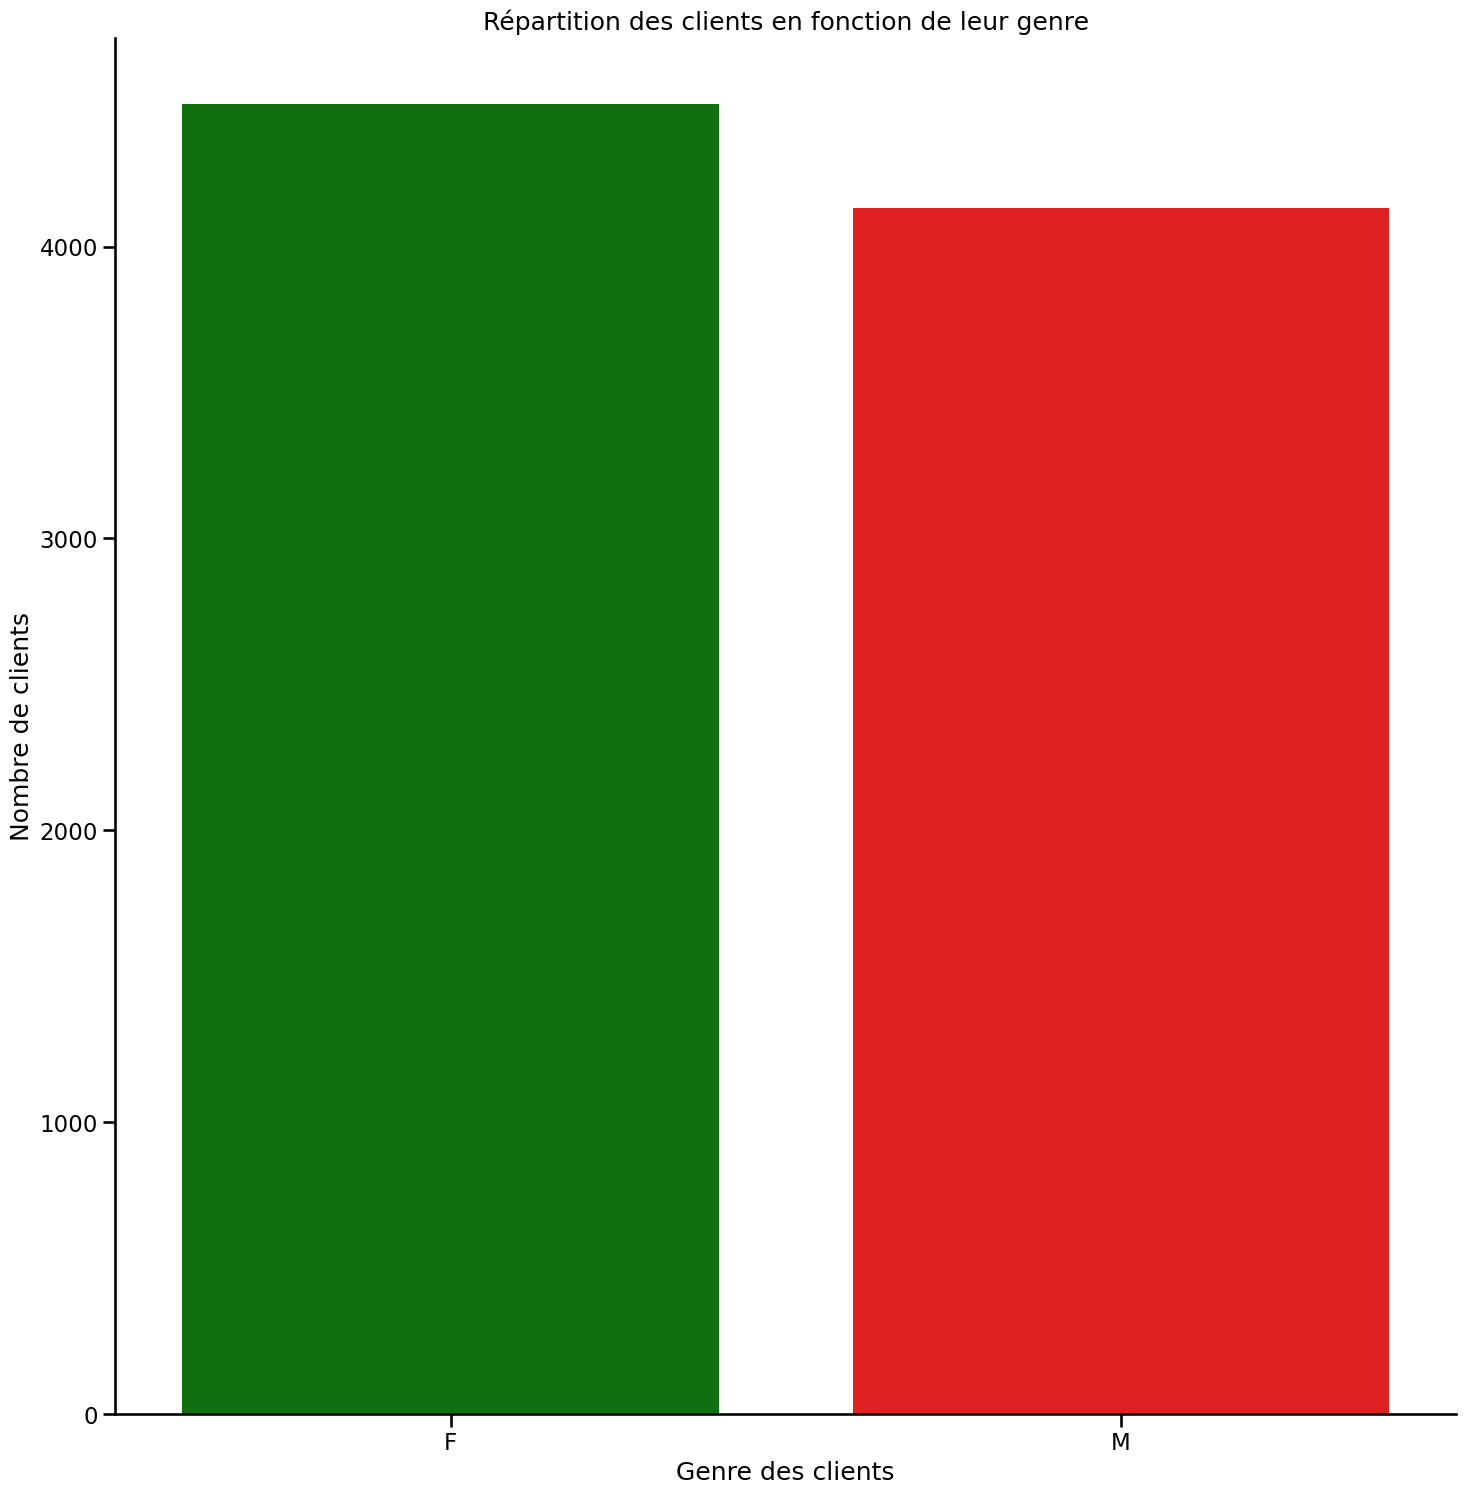

In [41]:
#Analyse de la répartition hommes/femmes
sns.set_context('talk')
custom_palette = {'F': 'green', 'M': 'red'}

sns.catplot(x='sex', data=customers, kind='count', palette=custom_palette, height=15)
plt.xlabel('Genre des clients')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients en fonction de leur genre')
plt.savefig('1 - Répartition HF.jpg')
plt.show()

In [42]:
#La répartition est à peu près équivalente, comme dans la population générale il y a un peu plus de femmes.
#On peut créer 2 dataframes pour de futures analyses.
customers_f = customers[customers['sex']=='F']
customers_m = customers[customers['sex']=='M']

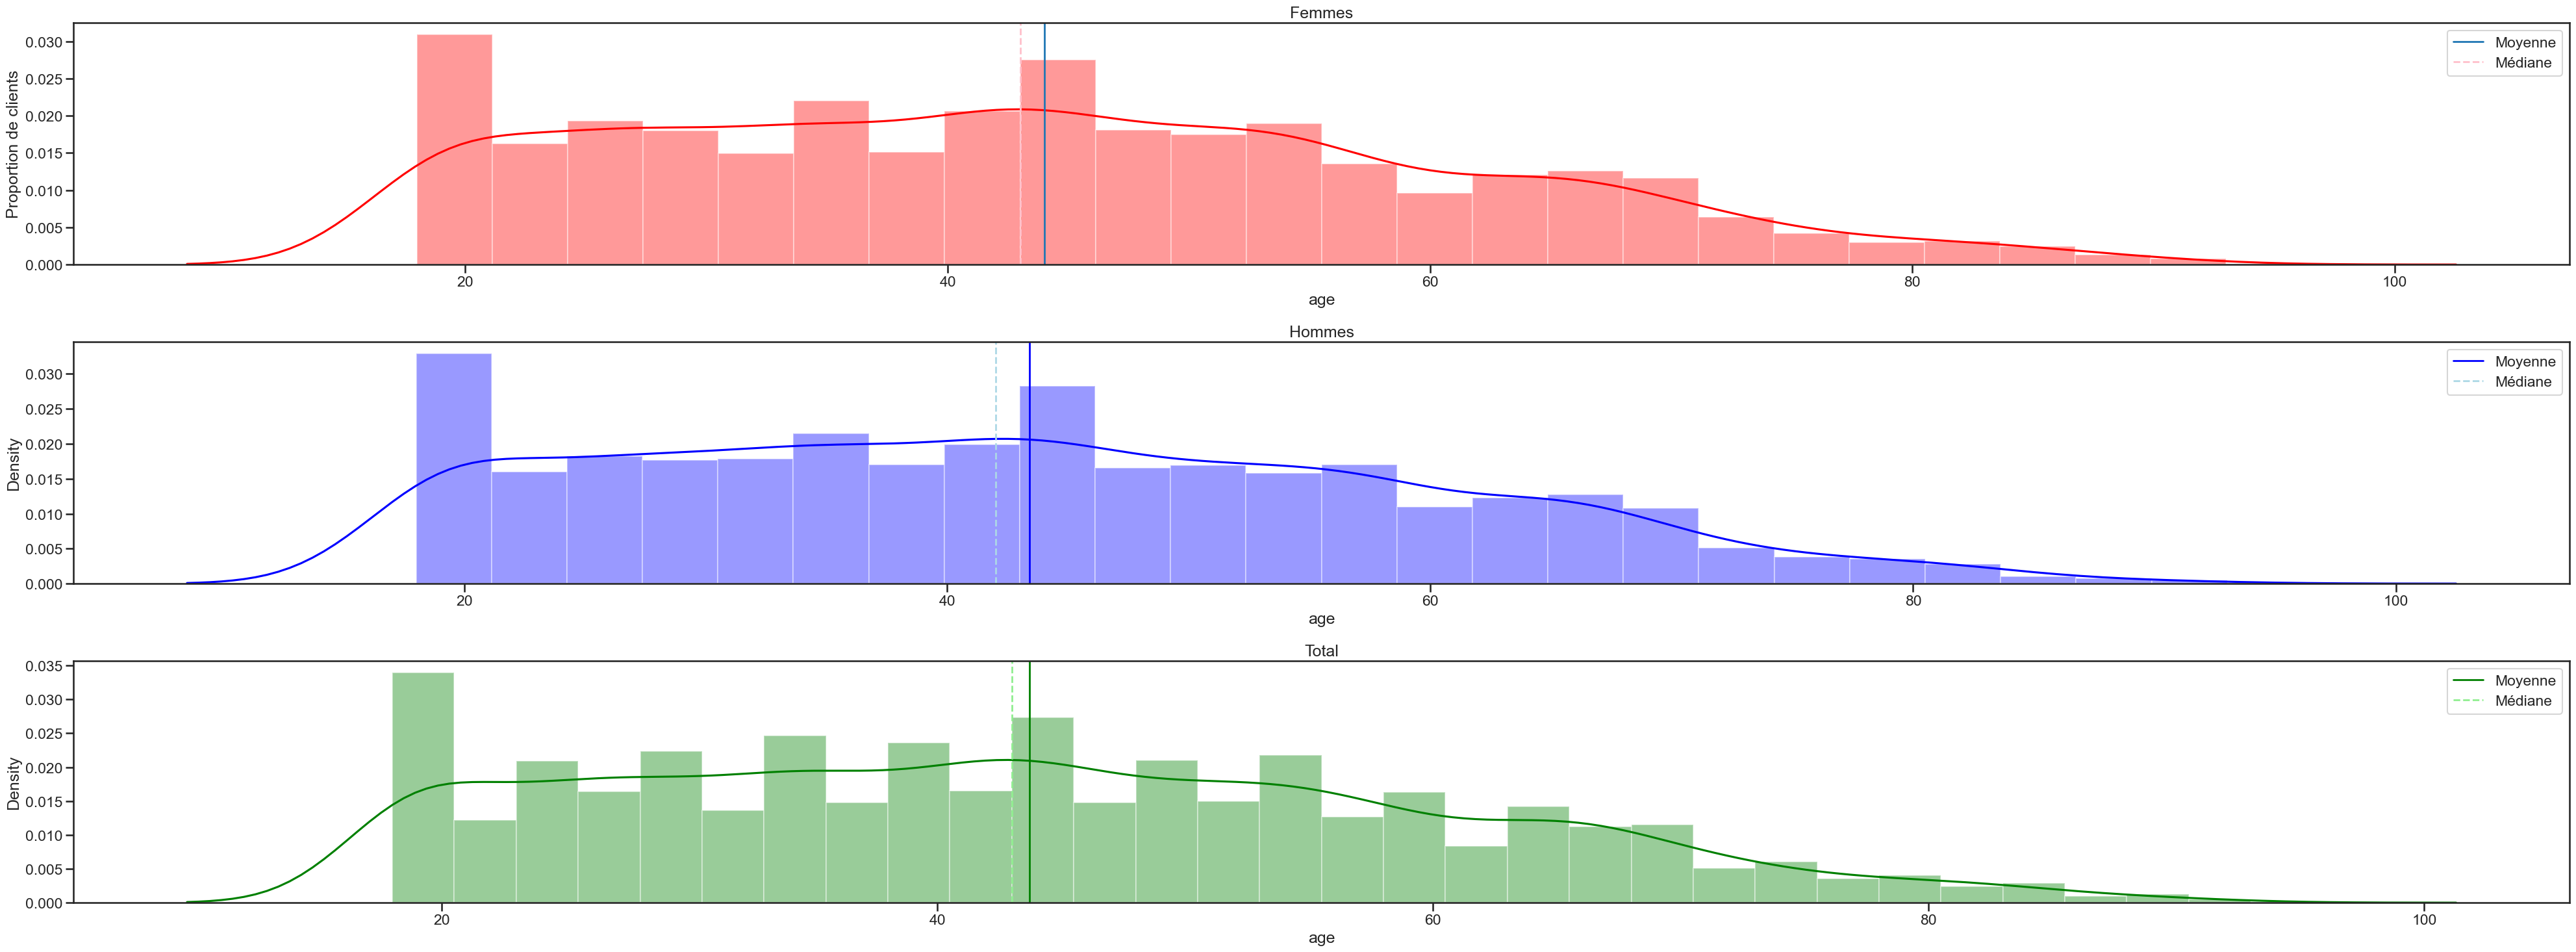

In [43]:
#Répartition de l'âge en fonction du genre
sns.set_style('ticks')
sns.set_context('talk')
plt.figure(figsize=(40, 15))

plt.subplot(3, 1, 1) 
sns.distplot(customers_f['age'], color='red')
plt.axvline(x=customers_f['age'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=customers_f['age'].median(), label='Médiane', linestyle='--', linewidth=2, color='pink')
plt.ylabel('Proportion de clients')
plt.title('Femmes')
plt.legend()

plt.subplot(3, 1, 2)
sns.distplot(customers_m['age'], color='blue')
plt.axvline(x=customers_m['age'].mean(), label='Moyenne', linestyle='-', linewidth=2, color='b')
plt.axvline(x=customers_m['age'].median(), label='Médiane', linestyle='--', linewidth=2, color='lightblue')
plt.title('Hommes')
plt.legend()

plt.subplot(3, 1, 3) 
sns.distplot(customers['age'], color='green')
plt.axvline(x=customers['age'].mean(), label='Moyenne', linestyle='-', linewidth=2, color='g')
plt.axvline(x=customers['age'].median(), label='Médiane', linestyle='--', linewidth=2, color='lightgreen')
plt.title('Total')
plt.legend()

plt.tight_layout()

plt.savefig('2 - Répartition des âges.jpg')
plt.show()


In [44]:
fem_skew = st.skew(customers_f['age'])
mal_skew = st.skew(customers_m['age'])
skew_total = st.skew(customers['age'])
print('Skewness Femmes = ' + str(fem_skew) + ' ; Skewness Hommes = ' + str(mal_skew) + ' ; Skewness Total = ' + str(skew_total))

Skewness Femmes = 0.3733111568791258 ; Skewness Hommes = 0.3438126359703028 ; Skewness Total = 0.36075109938550914


In [45]:
fem_kurt = st.kurtosis(customers_f['age'])
mal_kurt = st.kurtosis(customers_m['age'])
kurt_total = st.kurtosis(customers['age'])
print('Kurtosis Femmes = ' + str(fem_kurt) + ' ; Kurtosis Hommes = ' + str(mal_kurt) + ' ; Kurtosis Total = ' + str(kurt_total))

Kurtosis Femmes = -0.6122367483683164 ; Kurtosis Hommes = -0.6739856402878859 ; Kurtosis Total = -0.6369914555526575


In [46]:
print(customers_f.describe())
print(customers_m.describe())
print(customers.describe())

             birth          age
count  4490.000000  4490.000000
mean   1977.989755    44.010245
std      17.096698    17.096698
min    1929.000000    18.000000
25%    1966.000000    30.000000
50%    1979.000000    43.000000
75%    1992.000000    56.000000
max    2004.000000    93.000000
             birth          age
count  4131.000000  4131.000000
mean   1978.586299    43.413701
std      16.718043    16.718043
min    1929.000000    18.000000
25%    1966.000000    30.000000
50%    1980.000000    42.000000
75%    1992.000000    56.000000
max    2004.000000    93.000000
             birth          age
count  8621.000000  8621.000000
mean   1978.275606    43.724394
std      16.917958    16.917958
min    1929.000000    18.000000
25%    1966.000000    30.000000
50%    1979.000000    43.000000
75%    1992.000000    56.000000
max    2004.000000    93.000000


On peut remarquer que le nombre de clients ayant 18 ans est disproportioné par rapport aux autres âges. Il est probable que ce soit le site qui limite l'inscription aux plus de 18 ans, ceux de moins de 18 ans s'inscrivant avec cet âge.

Le skewness étant proche de zéro, la distribution des âges chez les femmes et les hommes est relativement symétrique. 
Le kurtosis proche de zéro aussi, indique que la courbe est plutôt plate et donc que la distribution des âges est plutôt concentrée autour de ses centres de probabilité.

<big><b>2 - Analyse des produits</b></big>

In [47]:
#Réinitialisation de l'index et de catégories
products.reset_index()
products = products[['id_prod', 'price', 'categ']]
products['categ'] = products['categ'].astype('category')
print(products.head())
products.dtypes

  id_prod  price categ
0  0_1421  19.99     0
1   0_724  21.78     0
2  0_1467   4.99     0
3  0_1076  25.11     0
4  0_2211   9.99     0


id_prod      object
price       float64
categ      category
dtype: object

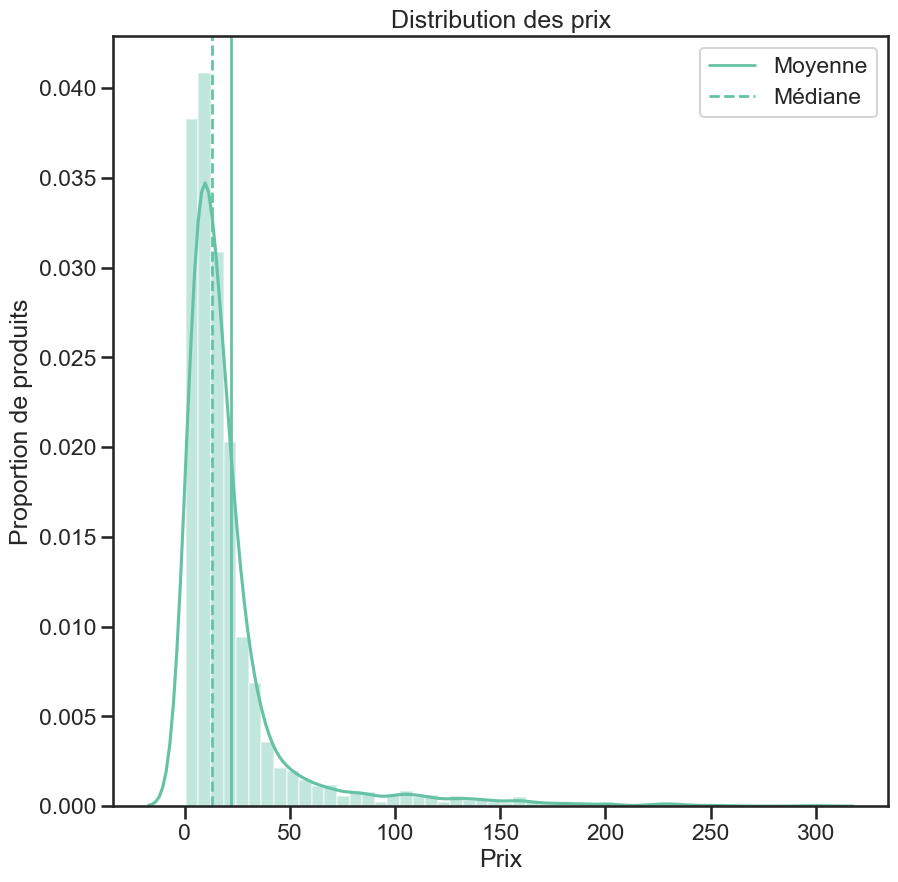

In [48]:
#Distribution des prix des produits
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

plt.figure(figsize=(10,10))
sns.distplot(products['price'])
plt.axvline(x=products['price'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=products['price'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Prix')
plt.ylabel('Proportion de produits')
plt.title('Distribution des prix')
plt.legend()

plt.savefig('3 - Distribution des prix.jpg')
plt.show()

In [49]:
#Skewness des prix
products_skew = st.skew(products['price'])
print('Skewness des prix : ', products_skew)

Skewness des prix :  3.7973497516077273


In [50]:
print(products.describe())

             price
count  3287.000000
mean     21.860511
std      29.845768
min       0.620000
25%       6.990000
50%      13.060000
75%      22.990000
max     300.000000


Cette fois, avec un skewness positif, la distribution des valeurs des prix est asymétrique. 
Le prix moyen des produits est de 21,86 EUR (std: 29,84 EUR) et la médiane est de 13,07 EUR. La médiane est plus précise que la moyenne dans ce cas car elle n'est pas sensible aux outliers (article à 300 EUR). *L'asymétrie vers la gauche (positive skew) des prix montre que la plupart des produits ont des petits prix.*

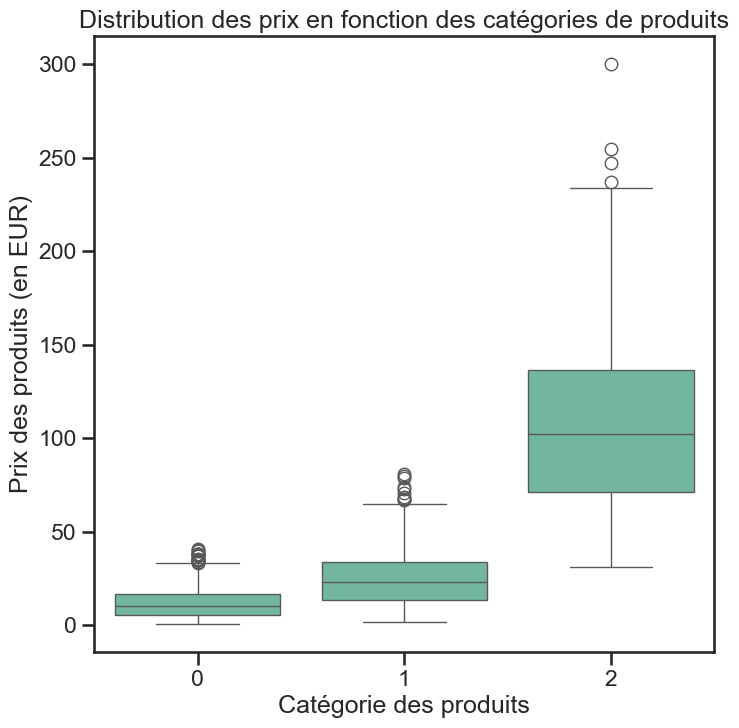

In [51]:
#Distribution des prix en fonction des catégories de produits
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize=(8,8))

sns.boxplot(data=products, x='categ', y='price')
plt.xlabel('Catégorie des produits')
plt.ylabel('Prix des produits (en EUR)')
plt.title('Distribution des prix en fonction des catégories de produits')

plt.savefig('4 - Répartition des produits par catégorie.jpg')

plt.show()

On peut observer que chaque catégorie de produit correspond à une fourchette de prix de différent ordre, la catégorie 2 ayant les prix les plus élevés et, la 0, les moins élevés.

<big><b>3 - Analyse des transactions</b></big>

In [52]:
#Passage de la date en datetime et création d'une nouvelle colonne
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['date'] = transactions['date'].apply(lambda x: x.strftime("%a %d %b %Y"))
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['mois-année'] = transactions['date'].apply(lambda x: x.strftime("%b %Y"))
transactions.head()

,date,id_prod,session_id,client_id,id_prod_prod,client_id_custom,mois-année
0,2021-03-01,0_1259,s_1,c_329,True,True,Mar 2021
1,2021-03-01,0_1390,s_2,c_664,True,True,Mar 2021
2,2021-03-01,0_1352,s_3,c_580,True,True,Mar 2021
3,2021-03-01,0_1458,s_4,c_7912,True,True,Mar 2021
4,2021-03-01,0_1358,s_5,c_2033,True,True,Mar 2021


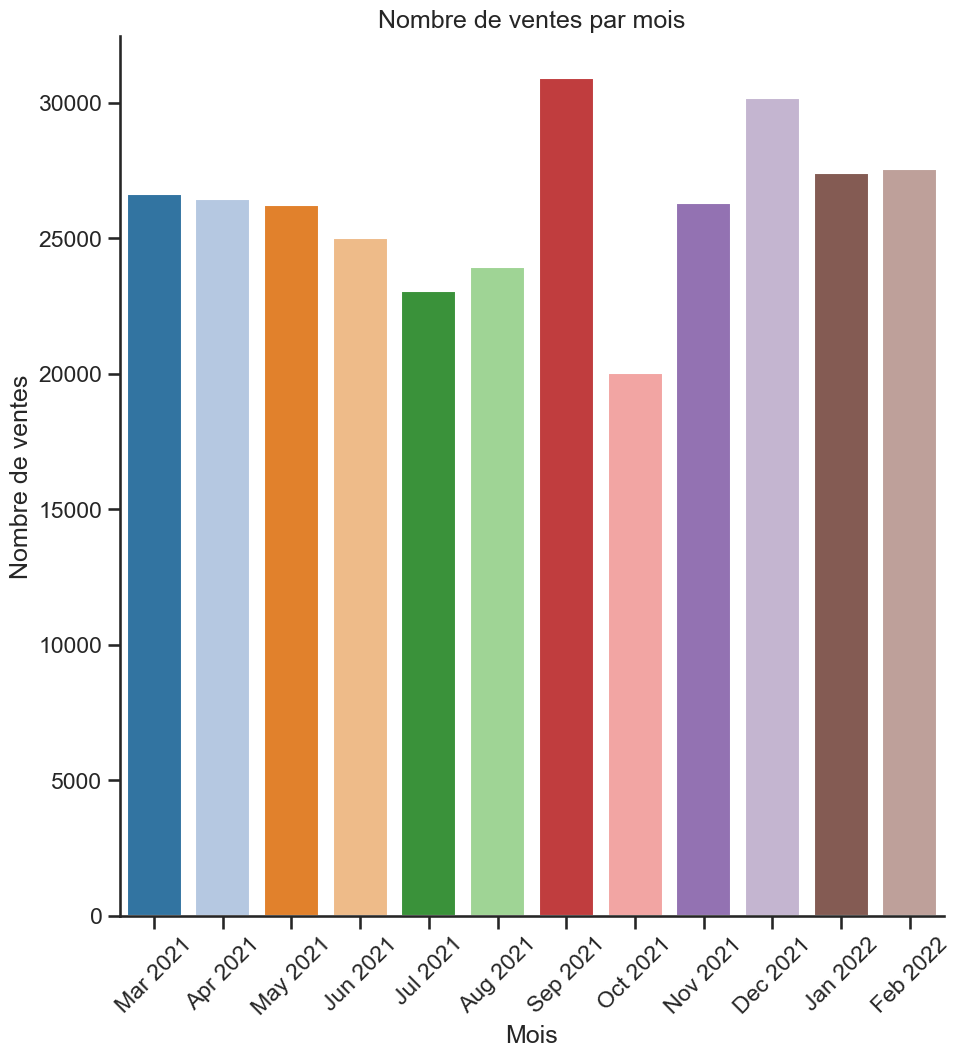

In [53]:
#Analyse du nombre de ventes par mois
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('tab20')

sns.catplot(x='mois-année', kind='count', height=10, data=transactions, hue='mois-année')
plt.xticks(rotation=45)
plt.xlabel('Mois')
plt.ylabel('Nombre de ventes')
plt.title('Nombre de ventes par mois')

plt.savefig('5 - Nombre de ventes mensuelles.jpg')

plt.show()

On peut observer que les ventes augmentent fortement en septembre, pour retomber en dessous de la moyenne annuelle de ventes, puis remontent à peu près au même niveau en décembre.

In [54]:
# Merge transactions, customers, and products DataFrames
df = pd.merge(transactions, customers, on='client_id')
df = pd.merge(df, products, on='id_prod')

# Convert 'mois-année' column to datetime format
df['mois-année'] = pd.to_datetime(df['mois-année'], format='%b %Y')

# Group by 'mois-année' and sum the 'price' column
transactions_ca = df.groupby('mois-année')['price'].sum().reset_index()

# Sort by 'mois-année'
transactions_ca = transactions_ca.sort_values('mois-année')

# Calculate cumulative sum of revenue
transactions_ca['cumulprice'] = transactions_ca['price'].cumsum()

# Print the DataFrame and total revenue
print(transactions_ca)
print('Total du chiffre d\'affaire :', round(transactions_ca['price'].sum(), 2))

   mois-année      price  cumulprice
0  2021-03-01  443044.59   443044.59
1  2021-04-01  436338.19   879382.78
2  2021-05-01  451405.70  1330788.48
3  2021-06-01  444937.79  1775726.27
4  2021-07-01  445703.29  2221429.56
5  2021-08-01  443277.16  2664706.72
6  2021-09-01  466891.00  3131597.72
7  2021-10-01  295320.59  3426918.31
8  2021-11-01  475229.68  3902147.99
9  2021-12-01  484825.84  4386973.83
10 2022-01-01  486633.98  4873607.81
11 2022-02-01  490225.43  5363833.24
Total du chiffre d'affaire : 5363833.24


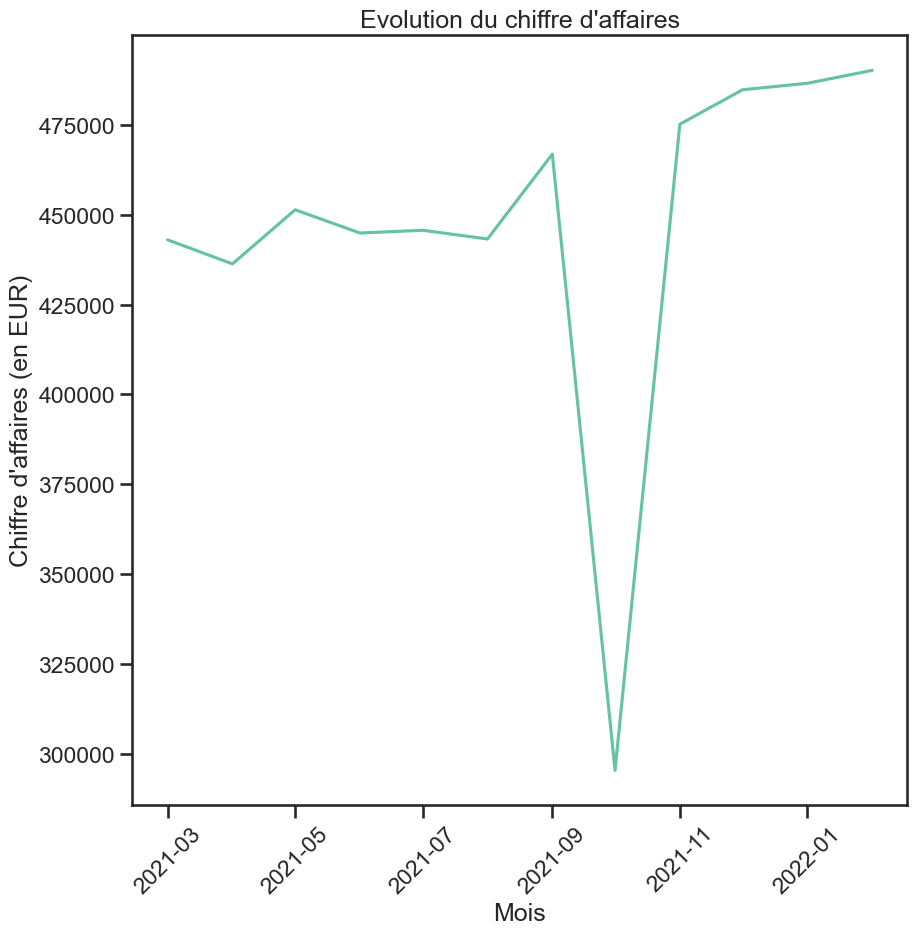

In [55]:
#Evolution du ca
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize = (10,10))

plt.plot(transactions_ca['mois-année'], transactions_ca['price'])
plt.xticks(rotation=45)
plt.xlabel('Mois')
plt.ylabel('Chiffre d\'affaires (en EUR)')
plt.title('Evolution du chiffre d\'affaires')

plt.savefig('6 - CA mensuel.jpg')

plt.show()

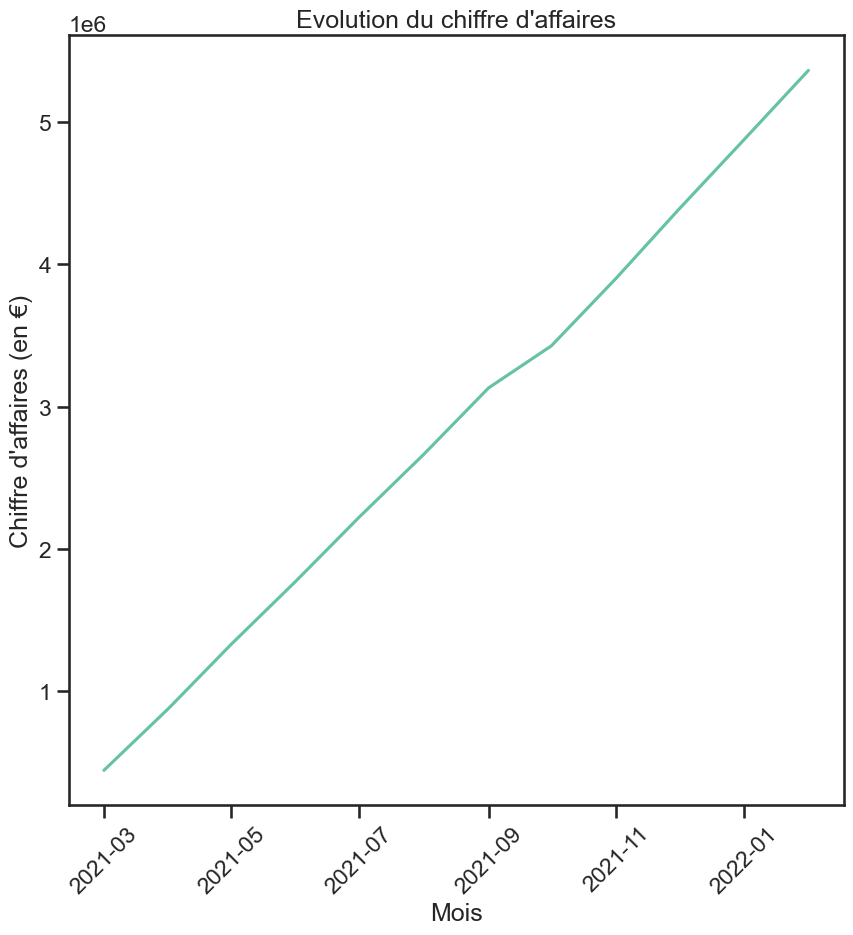

In [56]:
#Evolution du ca cumulée

sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize = (10,10))

plt.plot(transactions_ca['mois-année'], transactions_ca['cumulprice'])
plt.xticks(rotation=45)
plt.xlabel('Mois')
plt.ylabel('Chiffre d\'affaires (en €)')
plt.title('Evolution du chiffre d\'affaires')
plt.savefig('7 - CA cumulé.jpg')
plt.show()

In [57]:
#Pour comprendre pourquoi le CA baisse au mois d'octobre, il faut analyser le CA par catégorie de produit.
transactions = transactions.reset_index()
transactions_2 = pd.merge(transactions, products, on = ['id_prod'])
transactions_2.head()

,index,date,id_prod,session_id,client_id,id_prod_prod,client_id_custom,mois-année,price,categ
0,0,2021-03-01,0_1259,s_1,c_329,True,True,Mar 2021,11.99,0
1,401,2021-03-01,0_1259,s_202,c_1599,True,True,Mar 2021,11.99,0
2,3934,2021-03-05,0_1259,s_2114,c_107,True,True,Mar 2021,11.99,0
3,5563,2021-03-07,0_1259,s_2976,c_4215,True,True,Mar 2021,11.99,0
4,7694,2021-03-09,0_1259,s_4088,c_174,True,True,Mar 2021,11.99,0


In [58]:
transactions_2['mois-année'] = pd.to_datetime(transactions_2['date'])
transactions_2['mois-année'] = transactions_2['date'].apply(lambda x: x.strftime("%b %Y"))
transactions_2.head()

,index,date,id_prod,session_id,client_id,id_prod_prod,client_id_custom,mois-année,price,categ
0,0,2021-03-01,0_1259,s_1,c_329,True,True,Mar 2021,11.99,0
1,401,2021-03-01,0_1259,s_202,c_1599,True,True,Mar 2021,11.99,0
2,3934,2021-03-05,0_1259,s_2114,c_107,True,True,Mar 2021,11.99,0
3,5563,2021-03-07,0_1259,s_2976,c_4215,True,True,Mar 2021,11.99,0
4,7694,2021-03-09,0_1259,s_4088,c_174,True,True,Mar 2021,11.99,0


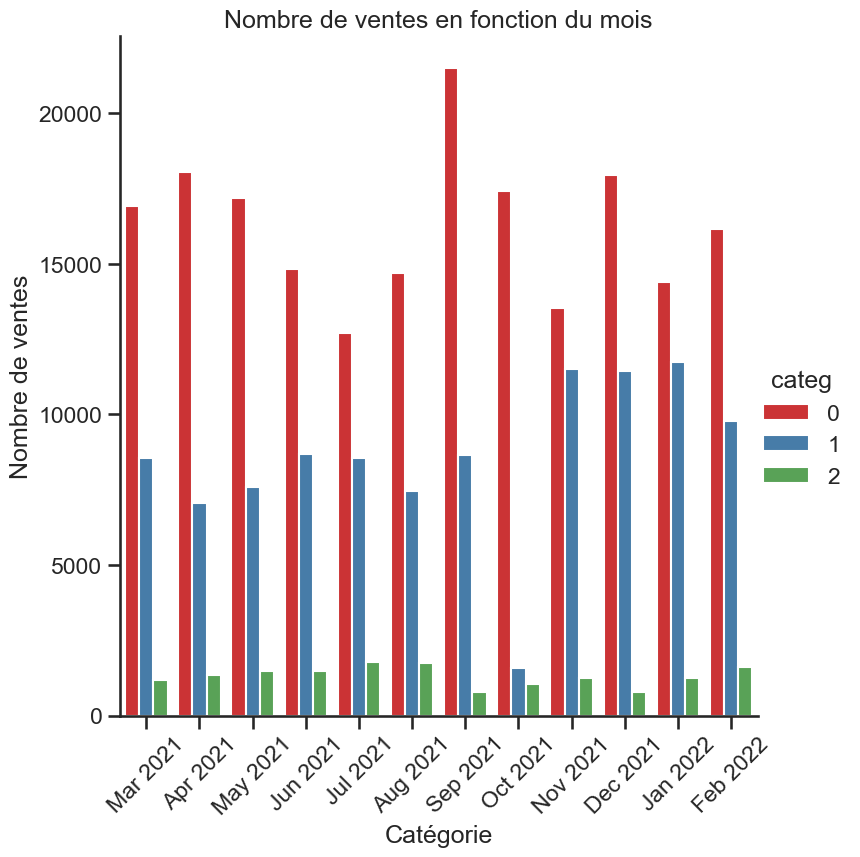

In [59]:
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set1')

sns.catplot(x='mois-année', data=transactions_2, hue='categ', kind='count', height=8)
plt.xticks(rotation=45)
plt.xlabel('Catégorie')
plt.ylabel('Nombre de ventes')
plt.title('Nombre de ventes en fonction du mois')
plt.savefig('8 - Nombre de ventes par mois et par catégorie.jpg')

plt.show()

Ce sont les ventes de la catégorie 1 qui chutent presque totalement en octobre tout en restant relativement similaire le reste des autres mois. *Il doit y avoir une perte de données.*

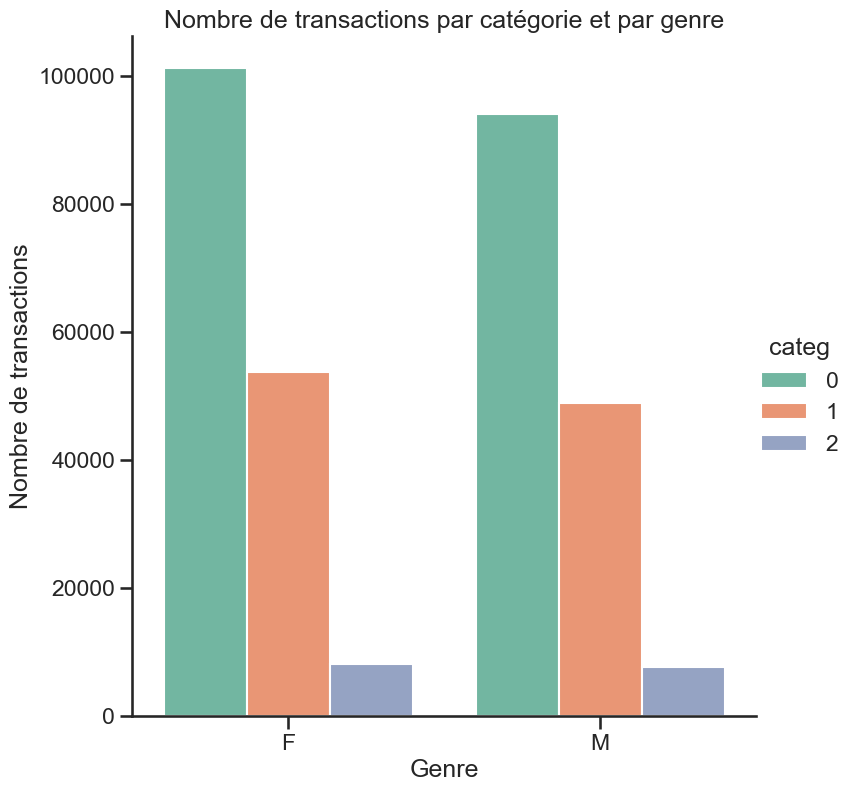

In [60]:
#Transactions par genre et catégorie de produits
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

sns.catplot(x='sex', hue='categ', data=df, kind='count', height=8)
plt.xlabel('Genre')
plt.ylabel('Nombre de transactions')
plt.title('Nombre de transactions par catégorie et par genre')

plt.savefig('9 - Nombre de transactions par genre et catégorie.jpg')

plt.show()

On peut observer que le genre n'influence pas la catégorie du produit acheté.

<big><b>4 - Analyse de concentration (Courbe de Lorenz et indice de Gini)</b></big>

In [61]:
# Top clients
df_customers = df.copy()
df_customers['count'] = 1
df_customers = df_customers.groupby('client_id')['count'].sum().reset_index()
df_customers = df_customers.sort_values('count', ascending=False)
top_10 = df_customers.head(10)
print(top_10)

     client_id  count
1267    c_2140    195
7711    c_7959    195
7787    c_8026    193
1771    c_2595    193
3022    c_3725    190
8191    c_8392    189
7116    c_7421    189
2512    c_3263    188
1196    c_2077    188
8373    c_8556    187


In [62]:
# Top produits
df_products = df.copy()
df_products['count'] = 1
df_products = df_products.groupby('id_prod')['count'].sum().reset_index()
df_products = df_products.sort_values('count', ascending=False)
top_10_prod = df_products.head(10)
print(top_10_prod)

     id_prod  count
2589   1_369   1015
2642   1_417    996
2639   1_414    966
2731   1_498    955
2651   1_425    941
2638   1_413    896
2620   1_398    891
2637   1_412    884
2630   1_406    881
2631   1_407    878


In [63]:
# On analyse la concentration des âges
df_age = df.copy()
df_age['count'] = 1
df_age = df_age.groupby('age')['count'].sum().reset_index()
df_age['cum_achat'] = df_age['count'].cumsum()

In [64]:
def gini(arr):
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

X = np.array(df_age['cum_achat'])
print('Indice de Gini : ', gini(X))

Indice de Gini :  0.2945215743588001


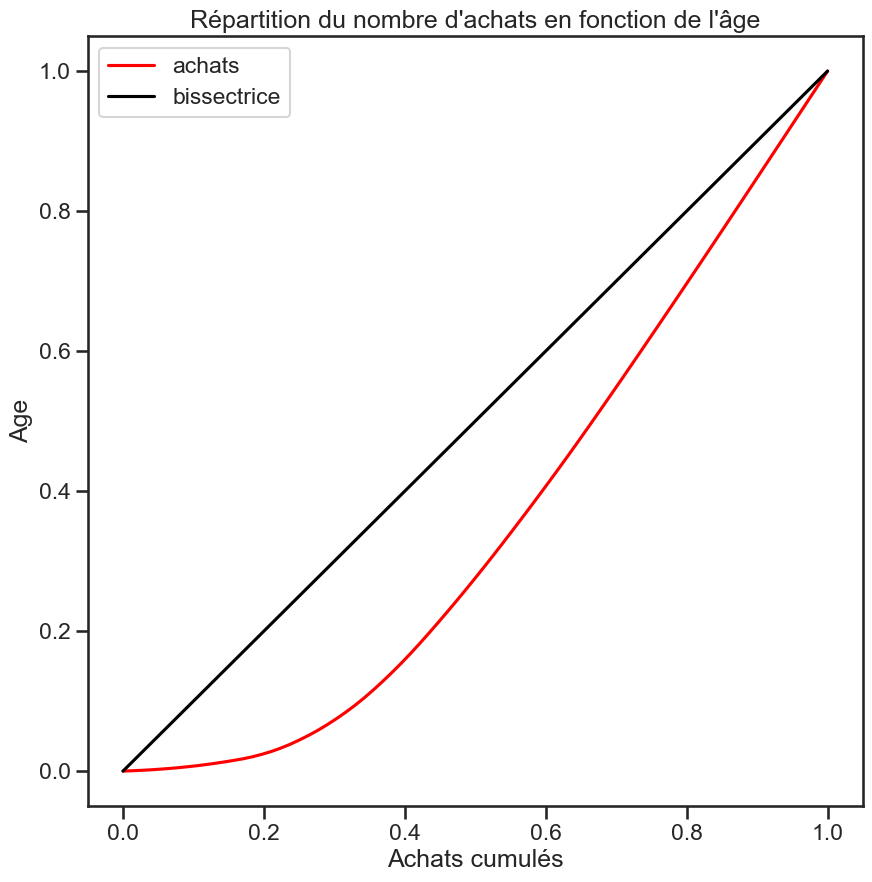

In [65]:
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]

fig, ax = plt.subplots(figsize=[10,10])
ax.plot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='red', label='achats')
ax.plot([0,1], [0,1], color='k', label='bissectrice')
plt.xlabel('Achats cumulés')
plt.ylabel('Age')
plt.title('Répartition du nombre d\'achats en fonction de l\'âge')
plt.legend()
plt.savefig('10 - Courbe de Lorenz.jpg')
plt.show()

L'indice de Gini relativement élévé et la courbe de Lorenz éloignée de la répartition parfaitement égalitaire *indiquent une répatition inégalitaire des achats en fonction de l'âge.*

<big><b>5 - Analyses bivariées</b></big>

5.1 - Corrélation entre le genre des clients et la catégorie des achats

In [66]:
df_categ = df[['sex', 'categ']]
df_categ = df_categ.astype('str')

In [67]:
X = 'sex'
Y = 'categ'
cont = df_categ[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True, margins_name='Total')
cont

categ,0,1,2,Total
sex,,,,
F,101206,53774,8122,163102
M,94064,48851,7634,150549
Total,195270,102625,15756,313651


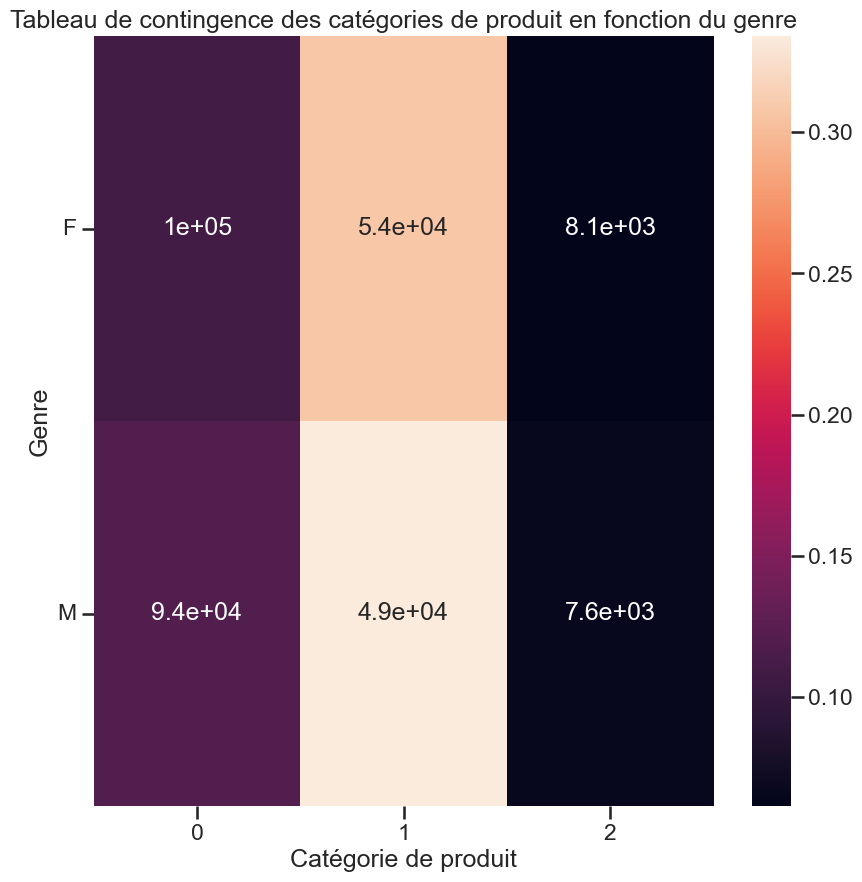

In [68]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(df_categ)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

plt.figure(figsize=(10, 10))
sns.heatmap(table.iloc[:-1, :-1], annot=c.iloc[:-1, :-1])
plt.xlabel('Catégorie de produit')
plt.ylabel('Genre')
plt.yticks(rotation=360)
plt.title('Tableau de contingence des catégories de produit en fonction du genre')
plt.savefig('11 - Tableau de contingences catégories par genre.jpg')
plt.show()

In [69]:
print('xi_n : ', xi_n)

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print('chi-squared :', st_chi2)
print('p-value :', st_p)

xi_n :  10.11086551372657
chi-squared : 10.110865513726571
p-value : 0.12006020526443334


La femmes achètent davantage de produits des catégories 1 et 2, tandis que les hommes sont beaucoup plus susceptibles que les femmes d'achèter dans la catégorie 0.

Cependant le calcul de la p-value montre en revanche que *cette non indépendance n'est pas significative statistiquement.*

4.2 - Corrélation entre l'âge des clients et le montant total des achats

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313651 entries, 0 to 313650
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              313651 non-null  datetime64[ns]
 1   id_prod           313651 non-null  object        
 2   session_id        313651 non-null  object        
 3   client_id         313651 non-null  object        
 4   id_prod_prod      313651 non-null  bool          
 5   client_id_custom  313651 non-null  bool          
 6   mois-année        313651 non-null  datetime64[ns]
 7   sex               313651 non-null  category      
 8   birth             313651 non-null  int64         
 9   age               313651 non-null  int64         
 10  classe_age        313651 non-null  category      
 11  price             313651 non-null  float64       
 12  categ             313651 non-null  category      
dtypes: bool(2), category(3), datetime64[ns](2), float64(1), int

In [71]:
df_age

,age,count,cum_achat
0,18,7348,7348
1,19,2182,9530
2,20,2224,11754
3,21,2032,13786
4,22,2175,15961
...,...,...,...
71,89,164,313207
72,90,159,313366
73,91,84,313450
74,92,115,313565


In [72]:
df_age2 = df.copy()
df_age2['count'] = 1
df_age2 = df_age2.groupby(by=['client_id', 'age']).agg({'count': 'sum', 'price': 'sum'}).reset_index()
df_age2.head()

,client_id,age,count,price
0,c_1,67,20,300.65
1,c_10,66,28,586.18
2,c_100,30,6,222.87
3,c_1000,56,56,980.02
4,c_1001,40,58,1102.45


In [73]:
x = df_age2['age']
y = df_age2['price']

print('rho de pearson :', st.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df_age2['price']
X = df_age2[['age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['age'],result.params['intercept']
print('r-squared : ', (st.pearsonr(x,y)[0])**2)

rho de pearson : -0.19036092308665029
indice de covariation : -1471.4425747585474
r-squared :  0.036237281038401584


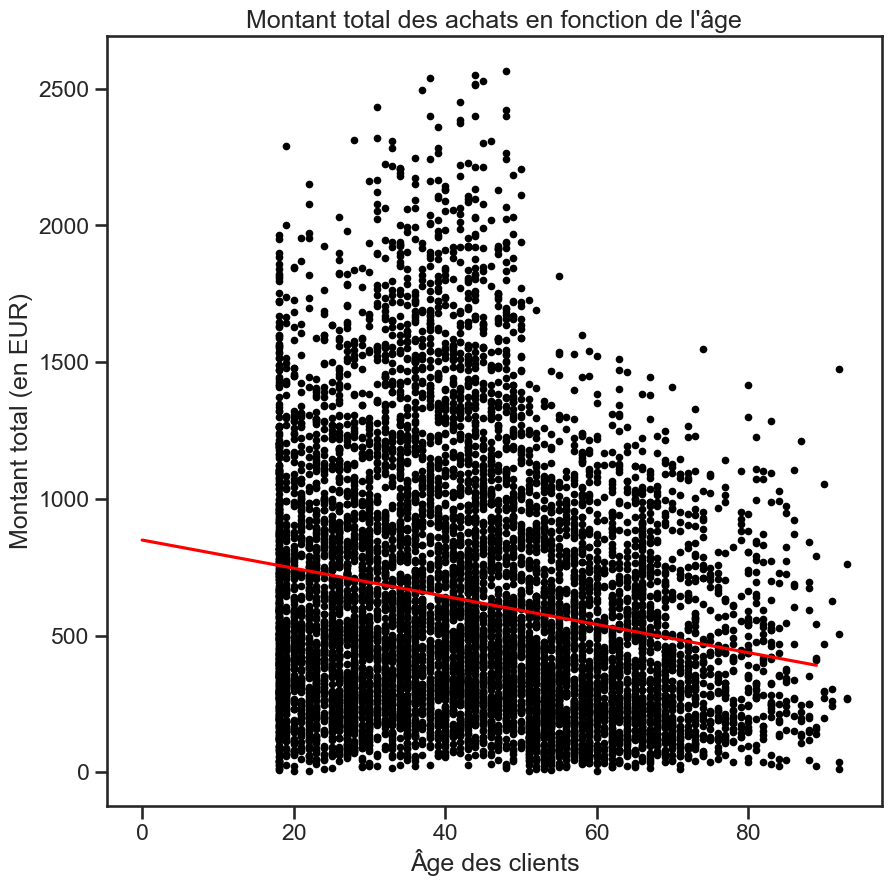

In [74]:
sns.set_context('talk')
sns.set_palette('Set1')

plt.figure(figsize=(10, 10))
plt.plot(df_age2.age, df_age2.price, ".", color='k')
plt.plot(np.arange(90), [a * x + b for x in np.arange(90)], color='r')
plt.xlabel("Âge des clients")
plt.ylabel("Montant total (en EUR)")
plt.title('Montant total des achats en fonction de l\'âge')
plt.savefig('12 - Régression montant achat par age.jpg')
plt.show()

Le coefficient de Pearson et le R² *ne montrent pas de corrélation entre l'âge des clients et le montant total des achats.*

4.3 - Corrélation entre l'âge des clients et la fréquence d’achat

In [75]:
df

,date,id_prod,session_id,client_id,id_prod_prod,client_id_custom,mois-année,sex,birth,age,classe_age,price,categ
0,2021-03-01,0_1259,s_1,c_329,True,True,2021-03-01,F,1967,55,51+,11.99,0
1,2022-01-13,0_1259,s_149171,c_1478,True,True,2022-01-01,F,1972,50,31-50,11.99,0
2,2022-01-29,0_1259,s_156829,c_7299,True,True,2022-01-01,M,1983,39,31-50,11.99,0
3,2021-12-15,0_1259,s_134720,c_5610,True,True,2021-12-01,M,1985,37,31-50,11.99,0
4,2021-10-15,0_1259,s_105013,c_1347,True,True,2021-10-01,M,1983,39,31-50,11.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313646,2022-02-19,2_81,s_167662,c_7616,True,True,2022-02-01,M,1993,29,18-30,86.99,2
313647,2022-02-17,2_89,s_166550,c_5845,True,True,2022-02-01,F,2000,22,18-30,107.99,2
313648,2021-07-24,0_807,s_66634,c_8273,True,True,2021-07-01,M,1991,31,18-30,1.99,0
313649,2021-09-26,1_408,s_95708,c_7402,True,True,2021-09-01,M,1945,77,51+,35.24,1


In [76]:
df_freq = df.copy()
df_freq['nb_achat'] = 1
df_freq = df_freq.groupby(['mois-année', 'age', 'session_id']).agg({'nb_achat': 'sum'}).reset_index()
df_freq['mois-année'] = pd.to_datetime(df_freq['mois-année']) 
df_freq = df_freq[['mois-année', 'age', 'nb_achat']]
df_freq = df_freq.sort_values(['mois-année', 'age'])
df_freq['freq_achat'] = df_freq['nb_achat']/df_freq['nb_achat'].sum()
df_freq.head()

,mois-année,age,nb_achat,freq_achat
0,2021-03-01,18,2,0.000006
1,2021-03-01,18,1,0.000003
2,2021-03-01,18,6,0.000019
3,2021-03-01,18,1,0.000003
4,2021-03-01,18,2,0.000006


In [77]:
x = df_freq['age']
y = df_freq['freq_achat']

print('rho de pearson :', st.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df_freq['freq_achat']
X = df_freq[['age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['age'],result.params['intercept']

print('r-squared : ', (st.pearsonr(x, y)[0])**2)

rho de pearson : -0.19398010753704523
indice de covariation : -1.1909819331809723e-05
r-squared :  0.03762828212008363


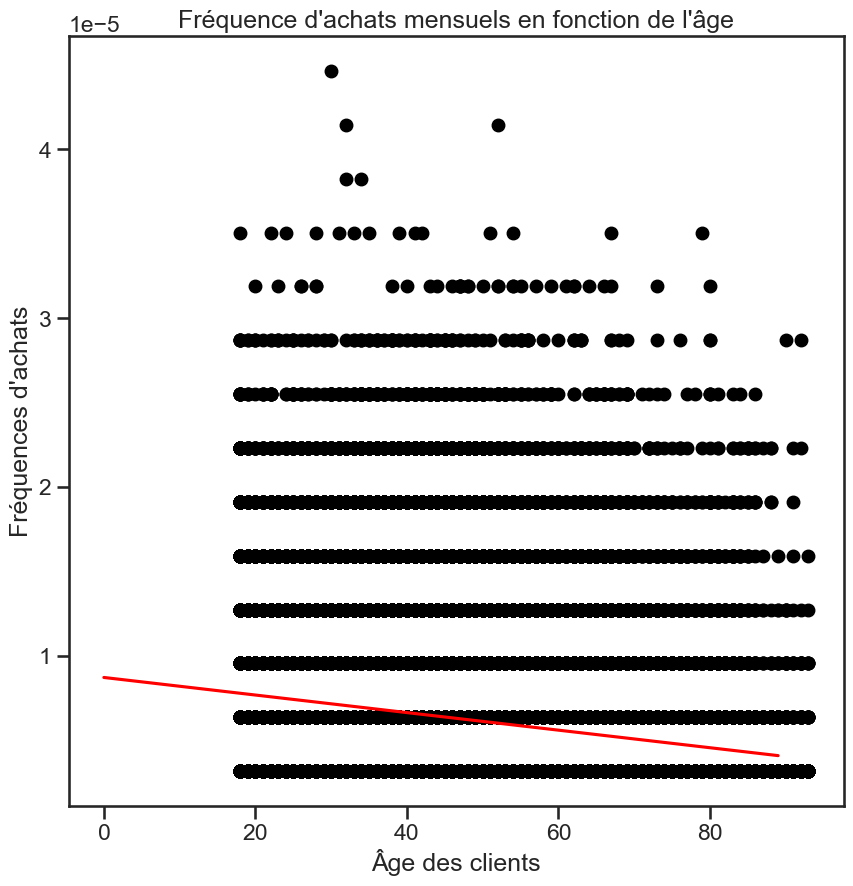

In [78]:
sns.set_context('talk')
sns.set_palette('Set1')

plt.figure(figsize=(10, 10))
plt.plot(df_freq.age, df_freq.freq_achat, "o", color='k')
plt.plot(np.arange(90), [a * x + b for x in np.arange(90)], color='r')
plt.xlabel("Âge des clients")
plt.ylabel("Fréquences d'achats")
plt.title("Fréquence d'achats mensuels en fonction de l'âge")
plt.savefig('13 - Fréquence achat mensuels par age.jpg')
plt.show()

Le coefficient de Pearson et le R² *ne montrent pas de corrélation entre nos données*. On peut poursuivre l'analyse en regroupant les clients par classes d'âge.

In [79]:
#Fréquence d'achat par classe d'âge
df['mois-année'] = pd.to_datetime(df['mois-année'])
df_freq = df.groupby(['mois-année', 'classe_age']).size().reset_index(name='nb_achat')
total_achats_total = df_freq['nb_achat'].sum()
df_freq['freq_achat'] = df_freq['nb_achat'] / total_achats_total

df_freq.head()

,mois-année,classe_age,nb_achat,freq_achat
0,2021-03-01,18-30,3633,0.011583
1,2021-03-01,31-50,16504,0.052619
2,2021-03-01,51+,6479,0.020657
3,2021-04-01,18-30,3720,0.011860
4,2021-04-01,31-50,16673,0.053158


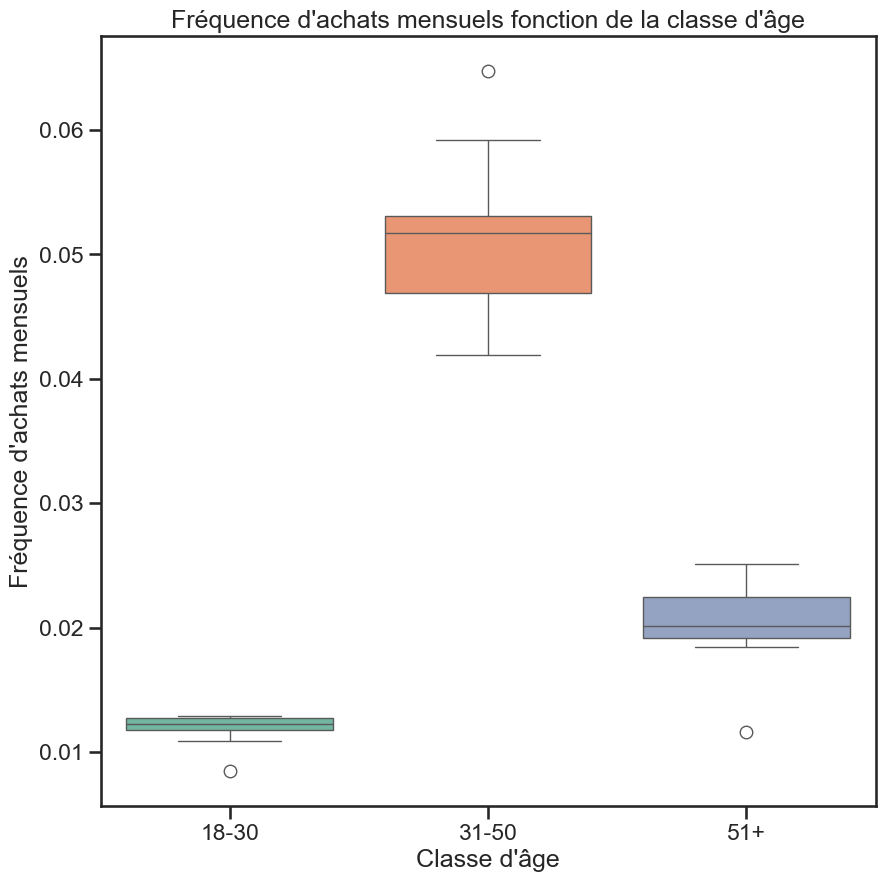

In [80]:
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize=[10,10])

sns.boxplot(x='classe_age', y='freq_achat', data=df_freq, palette='Set2')
plt.ylabel('Fréquence d\'achats mensuels')
plt.xlabel('Classe d\'âge')
plt.title('Fréquence d\'achats mensuels fonction de la classe d\'âge')
plt.savefig('14 - Fréquence anova achat par age.jpg')
plt.show()

In [81]:
X = df_freq['classe_age']
Y = df_freq['freq_achat']

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.9450062071204193


Cet eta² montre une importante corrélation entre la classe d'âge et la fréquence d'achat, et l'on constate sur le graphique que *ce sont les 31-50 qui achètent le plus fréquemment*.

4.4 - Corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles)

In [82]:
pd.set_option('mode.chained_assignment', None)
cols = ['session_id', 'id_prod']
df_pan_count = df[cols]
df_pan_count['taille_panier'] = 1
df_pan_count = df_pan_count.sort_values('session_id')
df_pan_count = df_pan_count.groupby('session_id').sum().reset_index()

cols_2 = ['session_id', 'id_prod', 'client_id', 'age', 'classe_age']
df_pan_moy = df[cols_2]
df_pan_moy = pd.merge(df_pan_moy, df_pan_count, on = 'session_id')
df_pan_count
df_pan_moy.head()

,session_id,id_prod_x,client_id,age,classe_age,id_prod_y,taille_panier
0,s_1,0_1259,c_329,55,51+,0_1259,1
1,s_149171,0_1259,c_1478,50,31-50,1_4061_7180_12590_1826,4
2,s_149171,1_406,c_1478,50,31-50,1_4061_7180_12590_1826,4
3,s_149171,0_1826,c_1478,50,31-50,1_4061_7180_12590_1826,4
4,s_149171,1_718,c_1478,50,31-50,1_4061_7180_12590_1826,4


In [83]:
x = df_pan_moy['age']
y = df_pan_moy['taille_panier']

print('rho de pearson :', st.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df_pan_moy['taille_panier']
X = df_pan_moy[['age']]
X = X.copy() 
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['age'],result.params['intercept']

print('r-squared : ', (st.pearsonr(x, y)[0])**2)

rho de pearson : -0.1608665300413687
indice de covariation : -3.6224216947858285
r-squared :  0.025878040487550578


<Figure size 1000x1000 with 0 Axes>

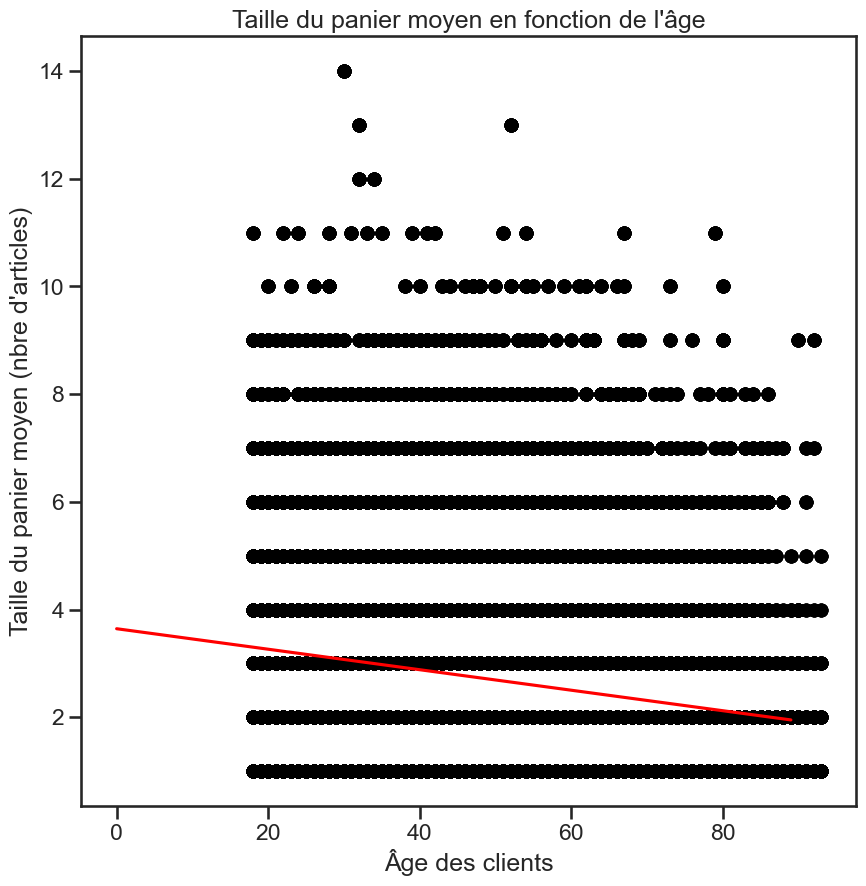

In [84]:
sns.set_context('talk')
sns.set_palette('Set1')
plt.figure(figsize=[10,10])

_ = plt.figure(figsize = (10,10))
_ = plt.plot(df_pan_moy.age,df_pan_moy.taille_panier, "o", color='k')
_ = plt.plot(np.arange(90),[a*x+b for x in np.arange(90)], color='r')
_ = plt.xlabel("Âge des clients")
_ = plt.ylabel("Taille du panier moyen (nbre d'articles)")
_ = plt.title('Taille du panier moyen en fonction de l\'âge')

_ = plt.savefig('15 - Régression panier moyen par age.jpg')

_ = plt.show()

Le coefficient de Pearson et le R² ne montrent *aucune corrélation entre l'âge des clients et la taille du panier*.

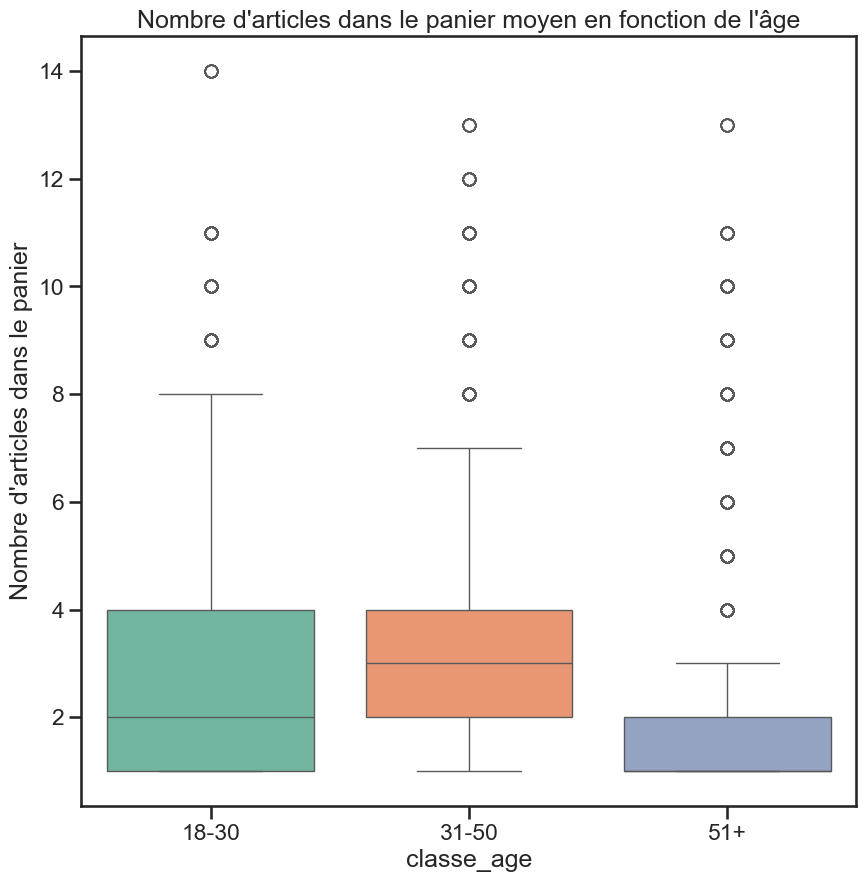

In [85]:
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='classe_age', y='taille_panier', data=df_pan_moy, palette='Set2')
_ = plt.ylabel('Nombre d\'articles dans le panier')
_ = plt.title('Nombre d\'articles dans le panier moyen en fonction de l\'âge')

_ = plt.savefig('16 - Anova panier moyen par age.jpg')

_ = plt.show()

In [86]:
X = df_pan_moy['classe_age'] # qualitative
Y = df_pan_moy['taille_panier'] # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.06168989573959316


Le coefficient eta² montre une légère corrélation entre la classe d'âge et la fréquence d'achat.

4.5 - Corrélation entre l'âge des clients et les catégories de produits achetés

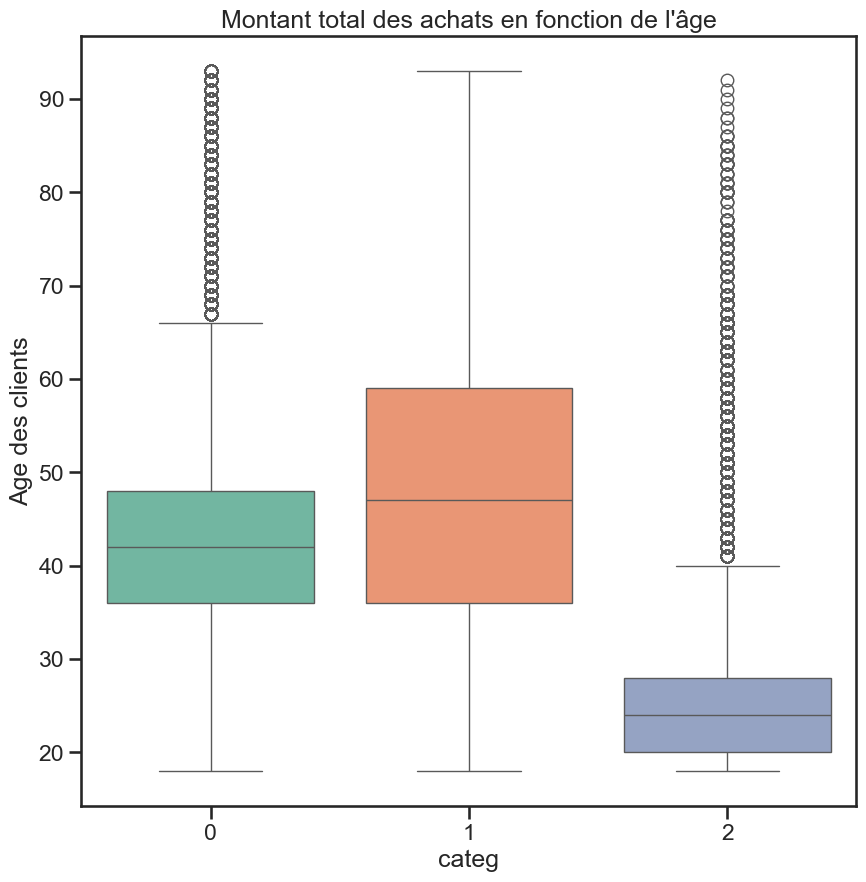

In [87]:
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='categ', y='age', data=df, palette='Set2')
_ = plt.ylabel('Age des clients')
_ = plt.title('Montant total des achats en fonction de l\'âge')

_ = plt.savefig('17 - Anova catégorie par age.jpg')

_ = plt.show()

In [88]:
X = df['categ']
Y = df['age']

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.1127902993231092


Le coefficient eta² montre une forte corrélation entre l'âge des clients et la catégorie d'achat. *Les clients les plus jeunes achètent principalement des produits de la catégorie 2, tandis que les deux autres catégories de produits sont achetées indistinctement par les clients.*